In [1]:
# import libraries
import numpy as np
import pandas as pd
import random
import csv
import scipy.stats as stats
import seaborn as sns
from collections import Counter
from collections import defaultdict
import math
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from random import randint

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

# initialize the plotting sizes
# set size
plt.rc('figure', figsize=(15, 8))
# subplots size
fizsize_with_subplots = (15, 8)
# histogram size
bin_size = 10

In [2]:
dates = pd.read_csv('data/dates.csv',header=None)
queries = pd.read_csv('data/queries.csv',header=None)
X = pd.read_csv('data/X.csv',header=None)
y = pd.read_csv('data/y.csv',header=None)

In [3]:
avg_year = pd.read_csv('average_yearly_flu_rate_4383.csv',header=None)

In [4]:
avg_year.head()

,0,1
0,2005-08-24,2.604156
1,2005-08-25,2.553375
2,2005-08-26,2.535065
3,2005-08-27,2.558312
4,2005-08-28,2.617273


In [5]:
dates['Date'] = pd.to_datetime(dates[0])
y.set_index(dates['Date'],inplace=True)
X.set_index(dates['Date'],inplace=True)

In [6]:
y.head()

,0
Date,
2005-08-24,3.12857
2005-08-25,3.23000
2005-08-26,3.23714
2005-08-27,3.24429
2005-08-28,3.25143


In [7]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
Date,,,,,,,,,,,,,,,,,,,,,
2005-08-24,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2005-08-25,2441.453870,162.536869,0.0,0.0,162.014142,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,162.291446,0.0
2005-08-26,1528.220180,176.061535,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2005-08-27,405.029314,0.000000,0.0,0.0,301.983868,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2005-08-28,1683.808180,474.855717,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,318.406892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [8]:
# data preprocessing and train-test split
# this data is well formed with no missing value and other symbols or labels that are non numerical.
# splitting the data into train and test

# Here we want the first 500 queries, ARIAMA only consider y, setting X has no effect
X = X.iloc[:, 0: 500]

# first with the last year as test
# use the last 365 of training set as validation set
test_size =365
val_size=365
length = X.shape[0]
train1_X = X[0:length-test_size*2]
val1_X = X[length-test_size*2:length-test_size]
train1_y = y[0:length-test_size*2]
val1_y = y[length-test_size*2:length-test_size]
test1_X = X[length-test_size:]
test1_y = y[length-test_size:]

#without validation set
train1_X2 = X[0:length-test_size]
train1_y2 = y[0:length-test_size]

# second with the last 2 year as test
test_size2 =365*2
train2_X = X[0:length-test_size2-val_size]
val2_X = X[length-test_size2-val_size:length-test_size2]
train2_y = y[0:length-test_size2-val_size]
val2_y = y[length-test_size2-val_size:length-test_size2]
test2_X = X[length-test_size2:]
test2_y = y[length-test_size2:]

#without validation set
train2_X2 = X[0:length-test_size2]
train2_y2 = y[0:length-test_size2]


print('X shape: ',X.shape,'  y shape: ',y.shape)
print('train1 X:',train1_X.shape,' train1 y:',train1_y.shape,' Test1 X shape:',test1_X.shape, ' Test1 y shape:',test1_y.shape)
print('train2 X:',train2_X.shape,' train2 y:',train2_y.shape,' Test2 X:',test2_X.shape,' Test2 y:',test2_y.shape)

X shape:  (4383, 500)   y shape:  (4383, 1)
train1 X: (3653, 500)  train1 y: (3653, 1)  Test1 X shape: (365, 500)  Test1 y shape: (365, 1)
train2 X: (3288, 500)  train2 y: (3288, 1)  Test2 X: (730, 500)  Test2 y: (730, 1)


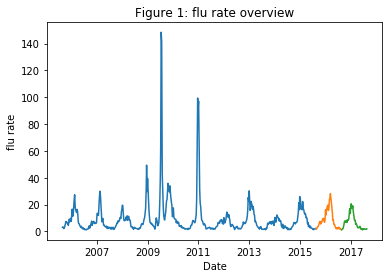

In [9]:
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = train1_y.copy()
df['y'] = train1_y.values

fig, ax = plt.subplots()
ax.plot(date[:3653],df.y,date[3653:4018],y.values[3653:4018],date[4018:],y.values[4018:])
plt.title("Figure 1: flu rate overview")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [10]:
df1 = avg_year.copy()
#df1['rate'] = train1_y2
df1.head()

,0,1
0,2005-08-24,2.604156
1,2005-08-25,2.553375
2,2005-08-26,2.535065
3,2005-08-27,2.558312
4,2005-08-28,2.617273


In [11]:
df=df1.iloc[:,1:2].copy()

In [12]:
df.head()

,1
0,2.604156
1,2.553375
2,2.535065
3,2.558312
4,2.617273


In [13]:
df3 = df[:4018].copy()
df4 = df[4018:].copy()

In [14]:
# the above plot shows the possible significant AR term may be 5
# anyway, just tune the possible choices
from statsmodels.tsa.arima_model import ARIMA
# fit model
model=ARIMA(endog=train1_y2.values,exog=df3,order=[2,1,14])
model_fit = model.fit(disp=0)
print(model_fit.summary())

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 4017
Model:                ARIMA(2, 1, 14)   Log Likelihood               -1500.531
Method:                       css-mle   S.D. of innovations              0.350
Date:                Wed, 05 Sep 2018   AIC                           3039.062
Time:                        20:56:03   BIC                           3158.730
Sample:                             1   HQIC                          3081.472
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0891      0.051     -1.758      0.079      -0.188       0.010
1              0.0096      0.005      1.749      0.080      -0.001       0.020
ar.L1.D.y      1.0109      0.040     25.254      0.0

In [15]:
model=ARIMA(endog=train1_y2.values,
            exog=df3,
            order=[1,2,15])
model_fit = model.fit(disp=0)
print(model_fit.summary())

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                 4016
Model:                ARIMA(1, 2, 15)   Log Likelihood               -1534.415
Method:                       css-mle   S.D. of innovations              0.353
Date:                Wed, 05 Sep 2018   AIC                           3106.830
Time:                        20:41:18   BIC                           3226.492
Sample:                             2   HQIC                          3149.238
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0041      0.002      2.126      0.034       0.000       0.008
1              -0.0004      0.000     -2.129      0.033      -0.001   -3.52e-05
ar.L1.D2.y      0.0035        nan        nan    

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [112]:
## now model selection via AIC
def evaluate_arima_model2(dataset,X, p,d,q):
    # fit model
    model = ARIMA(dataset.values,exog=X,order=(p,d,q))
    model_fit = model.fit(disp=0)
  
    error = model_fit.aic
    return error


## tune the parameters by rmse
def evaluate_models2(dataset,X, p_values, d_values, q_values):
    best_score=1000000000
    p0=-1
    d0=-1
    q0=-1
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    aic = evaluate_arima_model2(dataset,X, p,d,q)
                    if aic < best_score:
                        best_score = aic
                        p0=p
                        d0=d
                        q0=q
                    print(p,',',d,',',q,' AIC:',aic)
                except:
                    continue
    print('Best ARIMA (',p0,',',d0,',',q0,') AIC:',best_score)


In [113]:
p_values = [2]
d_values = [1]
q_values = [15]
df3 = df1.values[:4018]
evaluate_models2(train1_y2,df3, p_values, d_values, q_values)

Best ARIMA ( -1 , -1 , -1 ) AIC: 1000000000


In [106]:
p_values = [2]
d_values = [1]
q_values = [14]
df3 = df1.values[:4018]
evaluate_models2(train1_y2,df3, p_values, d_values, q_values)

Best ARIMA ( -1 , -1 , -1 ) AIC: 1000000000


In [16]:
# Defien the mearure matrics, MAE, RMSE, CORR
# define three metrics: mean absolute error, root mean squared error and Pearson's correlation.
from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_actual, y_pred)

from sklearn.metrics import mean_squared_error
from math import sqrt
# rmse = sqrt(mean_squared_error(y_actual, y_pred))

# np.correcoef returns Pearson product-moment correlation coefficients
def pearson_r(x,y):   
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]
# r = pearson_r(y_actual,y_pred)

train1 = train1_y2.values
test1 = test1_y.values

history = [x for x in train1]
predict = list()
training_mod = sm.tsa.statespace.SARIMAX(endog =train1,
                                  exog=df3,
                                  trend='n', order=(2,1,14),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
training_res = training_mod.fit()
training_mod.fit(disp=0)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [17]:
train1 = train1_y2.values
test1 = test1_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:4018].copy()
df4 = df[4018:].copy()

history = [x for x in train1]
predict = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:4018+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,14),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4.iloc[[t]]
    output = model_fit.forecast(steps=1,exog=exog_test)
    yhat = output.values[0]
    print(yhat)
    predict.append(yhat)
    obs = test1[t]
    history.append(obs)
    history=history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict)
rmse1 = sqrt(mean_squared_error(test1, predict))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

1.1832601184428975
1
1.1184681815181565
2
1.1047266461745264
3
1.1861946629164803
4
1.2146451021085594
5
1.255539459635711
6
1.2873086785897039
7
1.3247734638992323
8
1.35376350891538
9
1.3766445397035207
10
1.5191738166313922
11
1.5936180886481845
12
1.6814528704639042
13
1.7627952125635913
14
1.8460472623024349
15
1.9231773897295565
16
1.9519136494751732
17
1.9625808497076889
18
1.9739668750558703
19
2.002422780736025
20
2.0182603346344923
21
2.0391431835137297
22
2.055461481647275
23
2.052595662106644
24
2.4370431393125713
25
2.622697980462558
26
2.8231364961071854
27
3.014450186345156
28
3.210069763931278
29
3.397399516645192
30
3.484531619321149
31
3.9142131906107034
32
4.1642699442560405
33
4.427625460593299
34
4.686574462337356
35
4.947354168181782
36
5.20282285442891
37
5.2806482984833085
38
5.87663923870398
39
6.206118299471613
40
6.553860615728689
41
6.887296742393773
42
7.22884702253271
43
7.564604384502515
44
7.676625959882605
45
7.593091055606533
46
7.597985391819477
47
7.

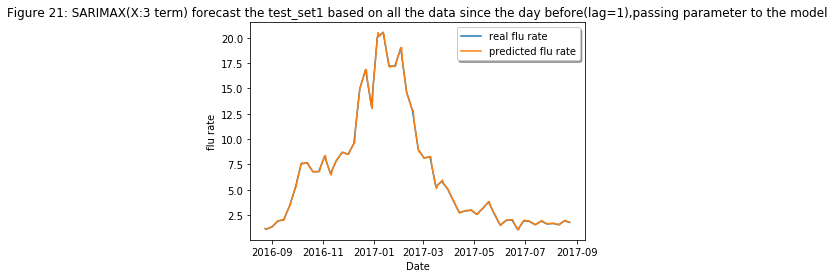

In [18]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],predict,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 21: SARIMAX(X:3 term) forecast the test_set1 based on all the data since the day before(lag=1),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [20]:
## lag=5

train1 = train1_y2.values[:4018-4]
test = y.values[4018-4:]
test1 = test1_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:4018].copy()
df4 = df[4018-4:].copy()

history = [x for x in train1]
predict2 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:4018-4+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,14),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+5]
    output = model_fit.forecast(steps=5,exog=exog_test)
    yhat = output.values[4]
    print(yhat)
    predict2.append(yhat)
    obs = test[t]
    history.append(obs)
    history=history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict2)
rmse1 = sqrt(mean_squared_error(test1, predict2))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict2
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

1.5408668259050327
1
1.4733021806975983
2
1.504347627032243
3
1.495985882536282
4
1.473760669323943
5
1.4397998343369829
6
1.4210898562039687
7
1.67499860007972
8
1.7006364517099986
9
1.7442907482219812
10
1.7558972295056092
11
1.7741245961908654
12
1.7758777782226065
13
1.8066243604298067
14
2.1723340833066533
15
2.2443287676376613
16
2.300048632869287
17
2.324785343291786
18
2.3424702050726496
19
2.352398634988866
20
2.3845912982681847
21
2.363666660271933
22
2.380463486861221
23
2.415976804044762
24
2.4021493260084608
25
2.3957008792569106
26
2.3778104310208805
27
2.370976389539923
28
3.469808778680953
29
3.6530473286881695
30
3.76735871418069
31
3.8448941824916987
32
3.922822407969684
33
3.9830729749287013
34
4.071045490326681
35
5.128084370733189
36
5.366918948795752
37
5.468479999201655
38
5.54913599898433
39
5.622680072912648
40
5.686716513966492
41
5.764200822211091
42
7.3124951724284415
43
7.6312138113440815
44
7.770393980249111
45
7.862009757104196
46
7.970099642631674
47
8.0

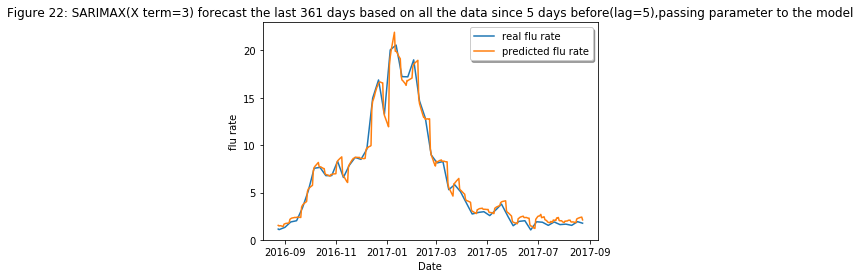

In [21]:
## lag=5
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],predict2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 22: SARIMAX(X term=3) forecast the last 361 days based on all the data since 5 days before(lag=5),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [22]:
## lag=10
train1 = train1_y2.values[:4018-9]
test = y.values[4018-9:]
test1 = test1_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:4018].copy()
df4 = df[4018-9:].copy()

history = [x for x in train1]
predict3 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:4018-9+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,14),
                                      
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+10]
    output = model_fit.forecast(steps=10,exog=exog_test)
    yhat = output.values[9]
    print(yhat)
    predict3.append(yhat)
    obs = test[t]
    history.append(obs)
    history=history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict3)
rmse1 = sqrt(mean_squared_error(test1, predict3))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict3
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

2.532468799746439
1
2.524799568053497
2
2.5380029158731654
3
2.539401701897228
4
2.5636312985990695
5
2.354282173246389
6
2.332628439620837
7
2.3785229594823423
8
2.3609602431552457
9
2.3455650242000905
10
2.3138532719421208
11
2.30454851471556
12
2.6523659918018048
13
2.661123717919284
14
2.7144073280314283
15
2.719391601449466
16
2.72233199193606
17
2.7021217638071886
18
2.7179835074610588
19
3.173957718792214
20
3.1875179386979493
21
3.253920152257795
22
3.2752357760824644
23
3.2690042110796074
24
3.251992087573183
25
3.263300775156427
26
3.2010641477934794
27
3.194929212091078
28
3.2437961126486403
29
3.217796774017465
30
3.2145836966707417
31
3.195971995136249
32
3.1912724790131795
33
4.643431725528432
34
4.708653485745031
35
4.826447072927889
36
4.888003828559289
37
4.8728285360803065
38
4.842032649673508
39
4.8481602856847275
40
6.139019594428891
41
6.187100028286754
42
6.297314526243458
43
6.3716472953880245
44
6.3659465313873
45
6.341092107673543
46
6.334754155421695
47
8.2708

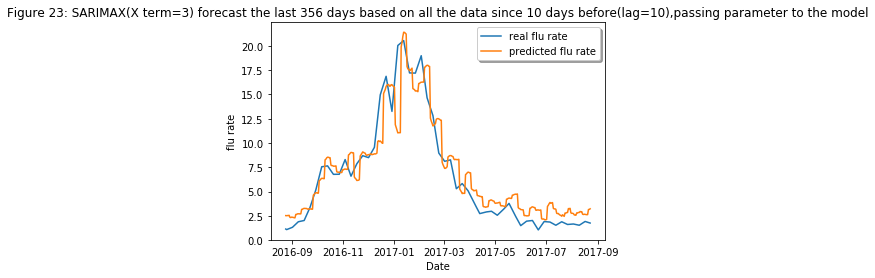

In [23]:
# visualize lag=10
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],predict3,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 23: SARIMAX(X term=3) forecast the last 356 days based on all the data since 10 days before(lag=10),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [24]:
## lag=14
train1 = train1_y2.values[:4018-13]
test = y.values[4018-13:]
test1 = test1_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:4018].copy()
df4 = df[4018-13:].copy()

history = [x for x in train1]
predict4 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:4018-13+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,14),
                                      
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+14]
    output = model_fit.forecast(steps=14,exog=exog_test)
    yhat = output.values[13]
    print(yhat)
    predict4.append(yhat)
    obs = test[t]
    history.append(obs)
    history=history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict4)
rmse1 = sqrt(mean_squared_error(test1, predict4))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict4
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

3.8612995029365127
1
3.8596566274130835
2
3.2842367775238466
3
3.3150583177273325
4
3.331489031550598
5
3.359970680608854
6
3.3718678974186935
7
3.372355429264358
8
3.3950721299339635
9
3.173668177384182
10
3.161859360758648
11
3.2216741631804573
12
3.215084116184301
13
3.197529208386916
14
3.1643572654132797
15
3.159133493569707
16
3.5251414514270842
17
3.514642501615786
18
3.548805521834972
19
3.5330360995090646
20
3.537665413568764
21
3.5183892962407337
22
3.544182951564545
23
4.020864613541715
24
4.009911662023423
25
4.05323948418363
26
4.045108914764597
27
4.039678882844758
28
4.021047152665213
29
4.03316571711254
30
3.967048860610687
31
3.9633021283288907
32
4.0166041318575845
33
3.9898067320117296
34
3.986881802659915
35
3.966476956209445
36
3.9642789573222013
37
5.472376012495858
38
5.449870844767531
39
5.483407370269883
40
5.460768410871541
41
5.452720791400058
42
5.4234779889817535
43
5.437320639040564
44
6.77482279573689
45
6.737022724384934
46
6.765065849944485
47
6.7568992

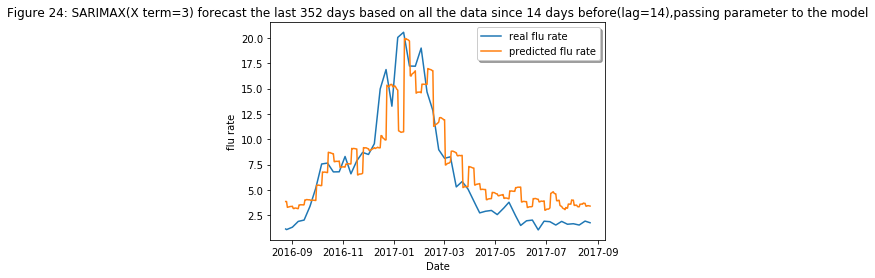

In [25]:
# visualize lag=14
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],predict4,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 24: SARIMAX(X term=3) forecast the last 352 days based on all the data since 14 days before(lag=14),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [27]:
## lag=28
train1 = train1_y2.values[:4018-27]
test = y.values[4018-27:]
test1 = test1_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:4018].copy()
df4 = df[4018-27:].copy()


history = [x for x in train1]
predict5 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:4018-27+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,14),
                                      
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+28]
    output = model_fit.forecast(steps=28,exog=exog_test)
    yhat = output.values[27]
    print(yhat)
    predict5.append(yhat)
    obs = test[t]
    history.append(obs)
    history=history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict5)
rmse1 = sqrt(mean_squared_error(test1, predict5))



6.345563622927293
1
6.332884754359096
2
5.675219587090632
3
5.695807303779783
4
5.713862658527252
5
5.801350565563243
6
5.811880165226695
7
5.821345387323761
8
5.838641105780176
9
5.978037944032546
10
6.005614632429987
11
6.006010938260129
12
5.992945613091559
13
5.986148443111215
14
5.972295381559697
15
5.973943143559296
16
5.630696648963344
17
5.652116903098012
18
5.663725651263656
19
5.683154020942685
20
5.693639052288759
21
5.6978195492390356
22
5.719895687458638
23
5.590181530913797
24
5.592221130082937
25
5.636102399809081
26
5.639462776163125
27
5.6368112267209405
28
5.625165637266455
29
5.627225133516593
30
5.849472883635157
31
5.847178485634653
32
5.873412622697073
33
5.866184387671213
34
5.87201076987954
35
5.863088067408362
36
5.87940525349543
37
6.15805855405637
38
6.154205201368775
39
6.182295231883896
40
6.183153608644006
41
6.1860426593622595
42
6.180209279302873
43
6.194195086083283
44
6.162584883693571
45
6.161086267796018
46
6.191604911523654
47
6.177078521622802
48
6

ValueError: Length of values does not match length of index

In [28]:
corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict5
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

3.459848551702907 3.9323725213370433 0.8347151408870077


In [ ]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],predict5,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 25:SARIMAX(X term=3) forecast the last 338 days based on all the data since 28 days before(lag=28),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()